# Decoding movies from V1

Authors: Steffen Schneider, Jin H Lee, Mackenzie Mathis.  

Modified for Cajal 2024 by: laquitainesteeve@gmail.com.

Duration: 1 hour

**Learning outcomes**:

  * Extract neural manifolds for different neural recording modalities (ca-imaging and neuropixels)
  * Compare neural manifolds in V1 evoked by movies features (DINO features) for different recording modalities
  * Extract neural manifolds that are consistent across neural recording modalities (Joint training)
  * Decode movie frames
  * Measure the inter and intra-area `linear consistencies` of the neural manifolds


**Modifications**:

  * The original dataset is large and takes a while to upload to Google drive. It was reduced to require minimal memory on your Google drive and to be uploaded in a few minutes.

**Requirements**:

  * You need at least `3GB` of space available on your Google Drive

**Configuration**
  * Change Runtime to GPU for fast processing, else running the entire notebook takes 1 hour with CPU.

**Readings**:

  * de Vries, S. E., Lecoq, J. A., Buice, M. A., Groblewski, P. A., Ocker, G. K., Oliver, M., ... & Koch, C. (2020). A large-scale standardized physiological survey reveals functional organization of the mouse visual cortex. Nature neuroscience, 23(1), 138-151.

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
!pip install --q --pre 'cebra[datasets,demos]'  # install cebra software
!pip install --q ipython-autotime               # time track colab notebook cells
%load_ext autotime

In [2]:
# import packages
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra.datasets
from cebra import CEBRA
import cebra
from google.colab import drive # to upload your dataset to google drive

# if cuda is available, setup to use GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

time: 6.51 s (started: 2024-03-22 11:07:28 +00:00)


In [3]:
# (3ms) custom functions
## to define CEBRA solvers

def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    data_loader.to(kwargs['device'])
    model = cebra.models.init(kwargs['model_architecture'], data_loader.dataset.input_dimension,
                              kwargs['num_hidden_units'],
                              kwargs['output_dimension'], norm).to(kwargs['device'])
    data_loader.dataset.configure_for(model)
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            tqdm_on=kwargs['verbose'])

def multi_session_solver(data_loader, **kwargs):
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    for dataset in data_loader.dataset.iter_sessions():
        dataset.to(kwargs['device'])

    model = torch.nn.ModuleList([
        cebra.models.init(m, dataset.input_dimension,
                          kwargs['num_hidden_units'], kwargs['output_dimension'], norm)
        for dataset, m in zip(data_loader.dataset.iter_sessions(), kwargs['model_architecture'])
    ]).to(kwargs['device'])

    for m in model:
        m.to(kwargs['device'])
    for n, dataset in enumerate(data_loader.dataset.iter_sessions()):
        dataset.configure_for(model[n])
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.MultiSessionSolver(model=model,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           tqdm_on=kwargs['verbose'])

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    dataset.configure_for(model)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

def _compute_emissions_multi(solver, dataset):

    return {
        i :
            get_emissions(model, session)
            for i, (model, session) in enumerate(zip(solver.model, dataset.iter_sessions()))
    }

def allen_frame_id_decode(train_fs, train_labels, test_fs, test_labels, modality = 'neuropixel', decoder = 'knn'):

    if modality == 'neuropixel':
        FACTOR = 4
    elif modality == 'ca':
        FACTOR = 1

    time_window = 1

    def feature_for_one_frame(feature):
        if isinstance(feature, torch.Tensor):
            feature = feature.cpu().numpy()
        return feature.reshape(-1,FACTOR,feature.shape[-1]).mean(axis = 1)

    train_fs = feature_for_one_frame(train_fs)
    test_fs = feature_for_one_frame(test_fs)


    if train_fs is None or test_fs is None:
        return [None], [None], None
    if decoder == 'knn':
        params = np.power(np.linspace(1, 10, 5, dtype=int), 2)
    elif decoder == 'bayes':
        params = np.logspace(-9, 3, 5)
    else:
        raise ValueError('Choose decoder between knn or bayes')
    errs = []

    for n in params:
        if decoder == 'knn':
            train_decoder = KNeighborsClassifier(n_neighbors=n,
                                                     metric='cosine')
        elif decoder == 'bayes':
            train_decoder = GaussianNB(var_smoothing = n)
        train_valid_idx = int(len(train_fs)/9*8)
        train_decoder.fit(train_fs[:train_valid_idx], train_labels[:train_valid_idx])
        pred = train_decoder.predict(train_fs[train_valid_idx:])
        err = train_labels[train_valid_idx:] - pred
        errs.append(abs(err).sum())

    if decoder == 'knn':
        test_decoder = KNeighborsClassifier(n_neighbors=params[np.argmin(errs)],
                                                     metric='cosine')
    elif decoder == 'bayes':
        test_decoder = GaussianNB(var_smoothing = params[np.argmin(errs)])

    test_decoder.fit(train_fs, train_labels)
    pred = test_decoder.predict(test_fs)
    frame_errors = pred - test_labels

    def _quantize_acc(frame_diff, time_window=1):

        true = (abs(frame_diff) < (time_window * 30)).sum()

        return true / len(frame_diff) * 100

    quantized_acc = _quantize_acc(frame_errors, time_window)

    return pred, frame_errors, quantized_acc

def consistency(feature1, feature2):
    """compute linear consistency
    """
    if len(feature1) == 32400:
        feature1 = feature1.reshape(-1, 4, feature1.shape[-1]).mean(axis=1)
    if len(feature2) == 32400:
        feature2 = feature2.reshape(-1, 4, feature2.shape[-1]).mean(axis=1)
    def _linear_fit(a,b):
        lin_model = LinearRegression()
        lin_model.fit(a, b)
        return lin_model.score(a, b)
    return _linear_fit(feature1, feature2), _linear_fit(feature2, feature1)


time: 2.58 ms (started: 2024-03-22 11:07:35 +00:00)


## Dataset description

- Original
  - We load Ca (30 Hz) and Neuropixels (120Hz) recording from pseudomice (stacked neurons from multiple mice), recorded while the Natural Movie1 stimulus (30sec, 30Hz) was passively shown during 10 repeats.
  - Pre-defined CEBRA datasets used for the paper experiments include varied dataset with different "cortex", "seed" and "num_neurons".
  - We set cortex "VISpm". You could set it to any values  from the original dataset ["VISp", "VISpm", "VISam", "VISrl", "VISal", "VISl"], "seed" from [111, 222, 333, 444, 555] and "num_neurons" from [10, 30, 50, 100, 200, 400, 600, 800, 900, 1000].

- Our minimal example
  - calcium_excitatory (we dropped the calcium_inhibitory) in area VISpm (we only use 2 files)

## (30m) Load the dataset

* Dataset
  * File name: `data.tgz`
  * Size: 2.92 GB; 3.14 GB on disk
  * Online source: https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Ffigshare.com%2Fs%2F60adb075234c2cc51fa3
  * Offline source: my hard drive (takes 5 min to download)

### (10m) Copy data folder from my Hard drive

* The original `.tgz` file was downloaded from https://figshare.com/s/60adb075234c2cc51fa3 and uncompressed. If you want to do so, go to the page and click the `download icon` next to data.tgz (2.92 GB) at the bottom left of the page (takes 5 min).

### (1m) Mount Google drive
When you run this code, Google Colab will prompt you to enter an `authorization code`. Follow the prompts to obtain the code and enter it into the provided field. Once you have entered the code, your Google Drive will be mounted in Google Colab.

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive
time: 47.5 s (started: 2024-03-22 11:07:35 +00:00)


### (15m) Upload the minimal dataset to your Google Drive

* allen.tgz
* Size: 1.5 GB

Depending on your internet speed, uploading typically takes about 1h/GB.

In [5]:
# (20m)
from google.colab import files
!rm allen.tgz
!rm -rf data/allen
uploaded = files.upload()

rm: cannot remove 'allen.tgz': No such file or directory


Saving allen.tgz to allen.tgz
time: 33min 49s (started: 2024-03-22 11:08:22 +00:00)


In [6]:
# (10s) decompress the data into a "/content/data/" path
!mkdir /content/data/
!tar -xvf allen.tgz --directory /content/data/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
allen/.DS_Store
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/allen_movie1_neuropixel/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/features/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/data_summary.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/visual_drift/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
allen/visual_drift/.DS_Store
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/visual_drift/LICENSE
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
allen/visual_drift/README.md
tar: Ignoring unknown extend

In [7]:
# @title (1s) Parametrize
CORTEX = 'VISam' #'VISp' #'VISpm'

SEED = 333
NUM_NEURONS = 800

time: 1.53 ms (started: 2024-03-22 11:42:26 +00:00)


### (50s) Initialize datasets for Cebra

Pre-defined demo and benchmark datasets.
`cebra.datasets` package contains actual implementations of
datasets. If you want to add a commonly used
(and public dataset) to CEBRA, this is the right
package to do it. Datasets here can be loaded e.g.
for testing, reproducing reference results and
benchmarking.

In [8]:
# training dataset
ca_train = cebra.datasets.init(f'allen-movie-one-ca-{CORTEX}-{NUM_NEURONS}-train-10-{SEED}')
np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{CORTEX}-{NUM_NEURONS}-train-10-{SEED}')
joint_train = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{CORTEX}-{NUM_NEURONS}-train-10-{SEED}')

# test dataset
ca_test = cebra.datasets.init(f'allen-movie-one-ca-{CORTEX}-{NUM_NEURONS}-test-10-{SEED}')
np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{CORTEX}-{NUM_NEURONS}-test-10-{SEED}')
joint_test = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{CORTEX}-{NUM_NEURONS}-test-10-{SEED}')

time: 21 s (started: 2024-03-22 11:42:26 +00:00)


In [9]:
# To see the list of available options
print(cebra.datasets.get_options())

['demo-discrete', 'demo-continuous', 'demo-mixed', 'demo-continuous-multisession', 'allen-movie-one-ca-VISp-10-train-10-111', 'allen-movie-one-ca-VISp-10-train-10-222', 'allen-movie-one-ca-VISp-10-train-10-333', 'allen-movie-one-ca-VISp-10-train-10-444', 'allen-movie-one-ca-VISp-10-train-10-555', 'allen-movie-one-ca-VISp-10-test-10-111', 'allen-movie-one-ca-VISp-10-test-10-222', 'allen-movie-one-ca-VISp-10-test-10-333', 'allen-movie-one-ca-VISp-10-test-10-444', 'allen-movie-one-ca-VISp-10-test-10-555', 'allen-movie-one-ca-VISp-30-train-10-111', 'allen-movie-one-ca-VISp-30-train-10-222', 'allen-movie-one-ca-VISp-30-train-10-333', 'allen-movie-one-ca-VISp-30-train-10-444', 'allen-movie-one-ca-VISp-30-train-10-555', 'allen-movie-one-ca-VISp-30-test-10-111', 'allen-movie-one-ca-VISp-30-test-10-222', 'allen-movie-one-ca-VISp-30-test-10-333', 'allen-movie-one-ca-VISp-30-test-10-444', 'allen-movie-one-ca-VISp-30-test-10-555', 'allen-movie-one-ca-VISp-50-train-10-111', 'allen-movie-one-ca-VISp

Text(0.5, 1.0, 'Neuropixels')

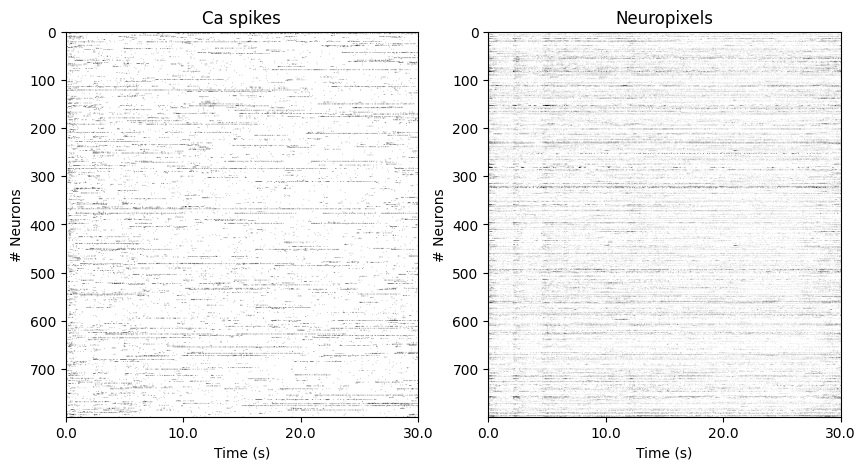

time: 857 ms (started: 2024-03-22 11:42:47 +00:00)


In [10]:
# @title Plot datasets
# 2s
plt.figure(figsize=(10,5))
ax1= plt.subplot(1,2,1)
ax1.imshow(ca_train.neural.cpu().numpy()[:900].T, aspect = 'auto', vmax = 1, vmin = 0, cmap ='gray_r')
ax1.set_ylabel('# Neurons')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(np.linspace(0,900, 4))
ax1.set_xticklabels(np.linspace(0,30, 4))
ax1.set_title('Ca spikes')
ax2= plt.subplot(1,2,2)
ax2.imshow(np_train.neural.cpu().numpy()[:3600].T, aspect = 'auto', vmax = 1, vmin = 0, cmap ='gray_r')
ax2.set_ylabel('# Neurons')
ax2.set_xlabel('Time (s)')
ax2.set_xticks(np.linspace(0,3600, 4))
ax2.set_xticklabels(np.linspace(0,30, 4))
ax2.set_title('Neuropixels')

## (8s) Visualize DINO features of the video frames

- CEBRA datasets include the video frames (Natural movie 1 from Allen Visual Coding) features extracted from a vision transformer model, DINO (https://arxiv.org/abs/2104.14294).
- Here we visualize DINO features using 2D tSNE.

(-46.99207725524902, 43.92896690368652, -50.75965518951416, 45.52811450958252)

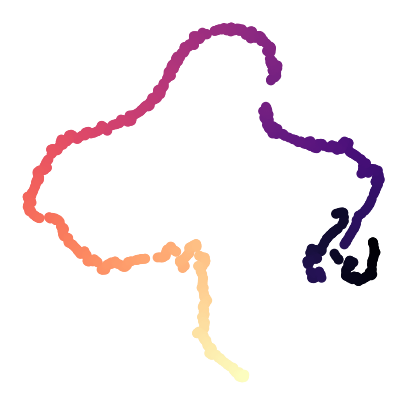

time: 6.19 s (started: 2024-03-12 13:02:05 +00:00)


In [ ]:
# reduce dimensionality to two dimensions with TSNE for plotting
dino_tsne = TSNE(n_components = 2)
dino_tsne_viz = dino_tsne.fit_transform(ca_train.index[:900,:])

# plot
fig = plt.figure(figsize = (5,5))
plt.scatter(dino_tsne_viz[:,0], dino_tsne_viz[:,1], cmap = 'magma', c = np.arange(900))
plt.axis('off')

## (4m) Extract separate neural manifolds from ca & neuropixel datasets

- CEBRA technique trained on a movie window of 1 frame
- using DINO features as behavior labels

In [ ]:
# @title (1s) Parametrize
TRAIN_STEPS = 100 #10000

ca_loader = cebra.data.ContinuousDataLoader(ca_train, num_steps = TRAIN_STEPS, batch_size = 512, conditional = 'time_delta', time_offset =1)
np_loader = cebra.data.ContinuousDataLoader(np_train, num_steps = TRAIN_STEPS, batch_size = 512, conditional = 'time_delta', time_offset = 1)

# calcium-imaging data
cebra_ca = single_session_solver(data_loader = ca_loader, model_architecture = 'offset1-model',
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

# neuropixels data
cebra_np = single_session_solver(data_loader = np_loader, model_architecture = 'resample1-model',
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

time: 479 ms (started: 2024-03-12 13:02:17 +00:00)


In [ ]:
# @title (30s) Train on Ca data
# train calcium imaging data (CPU, 100 steps)
# this takes 40 min on CPU for the original 10000 training steps
cebra_ca.fit(ca_loader)
cebra_ca_emb = _compute_emissions_single(cebra_ca, ca_train)

pos: -0.9015 neg:  6.6440 total:  5.7425 temperature:  1.0000: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]

time: 23.7 s (started: 2024-03-12 13:02:17 +00:00)


In [ ]:
# @title (3m) Train on Neuropixels
# train neuropixels data (CPU, 100 steps)
cebra_np.fit(np_loader)
cebra_np_emb = _compute_emissions_single(cebra_np, np_train)

pos: -0.8197 neg:  6.5155 total:  5.6959 temperature:  1.0000: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


time: 2min 35s (started: 2024-03-12 13:02:41 +00:00)


(-0.14161273874342442,
 0.09912300892174244,
 -0.11174614615738392,
 0.1492486957460642)

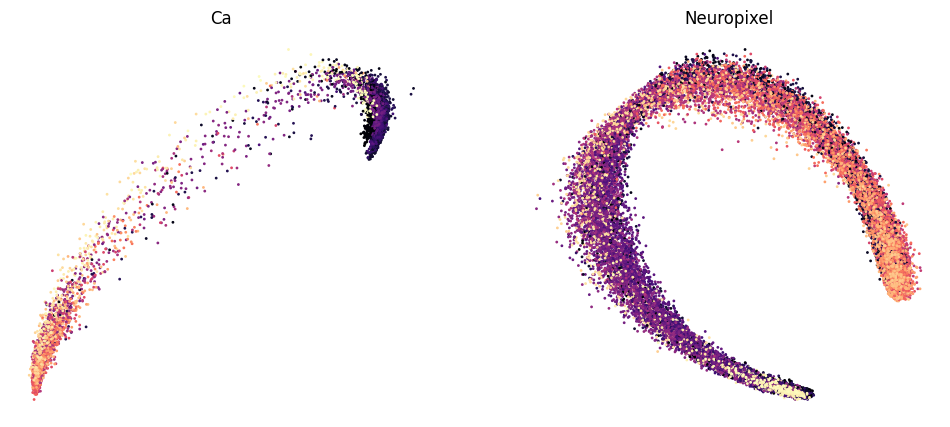

time: 1.53 s (started: 2024-03-12 13:05:17 +00:00)


In [ ]:
# @title (2s) Plot neural manifolds
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Ca')
ax1.scatter(cebra_ca_emb[:,0], cebra_ca_emb[:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')

ax2 = plt.subplot(122)
ax2.set_title('Neuropixel')
ax2.scatter(cebra_np_emb[:,0], cebra_np_emb[:,1], cmap = 'magma', c = np.tile(np.repeat(np.arange(900),4),9), s=1)
ax2.axis('off')

## (15m) Extract cross-modality manifolds


- We use multisession-CEBRA to jointly train Ca and ephys recording, which generates consistent embeddings across the two recording modalities.

In [ ]:
# @title (1s) Parametrize
TRAIN_STEPS = 500

joint_loader = cebra.data.ContinuousMultiSessionDataLoader(
    joint_train,
    num_steps = TRAIN_STEPS,
    batch_size = 512,
    conditional = 'time_delta',
    time_offset=1
    )

cebra_joint = multi_session_solver(
    data_loader = joint_loader,
    model_architecture = ['offset1-model', 'resample1-model'],
    distance = 'cosine',
    num_hidden_units = 128,
    output_dimension = 128,
    verbose = True,
    device = DEVICE,
    temperature = 1,
    learning_rate = 3e-4
    )

time: 321 ms (started: 2024-03-12 13:05:45 +00:00)


In [ ]:
# @title (15m) Train jointly
cebra_joint.fit(joint_loader)
cebra_joint_embs = _compute_emissions_multi(cebra_joint, joint_train)

pos: -0.9167 neg:  7.1093 total:  6.1926 temperature:  1.0000: 100%|██████████| 500/500 [15:40<00:00,  1.88s/it]


time: 15min 44s (started: 2024-03-12 13:05:45 +00:00)


(-0.15849263295531274,
 0.1665052704513073,
 -0.2531373642385006,
 0.27612909600138663)

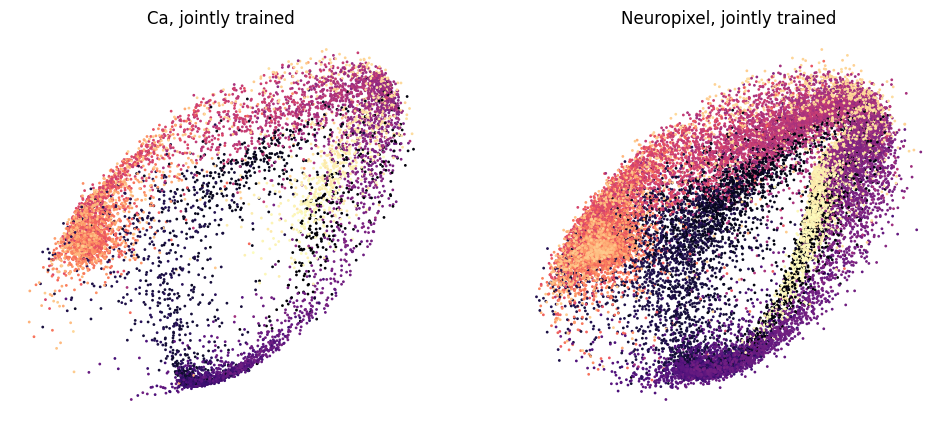

time: 1.43 s (started: 2024-03-12 13:25:22 +00:00)


In [ ]:
# @title (2s) Plot neural manifolds
fig = plt.figure(figsize = (12,5))

# ca-imaging
ax1 = plt.subplot(121)
ax1.set_title('Ca, jointly trained')
ax1.scatter(cebra_joint_embs[0][:,0], cebra_joint_embs[0][:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')

# neuropixels
ax2 = plt.subplot(122)
ax2.set_title('Neuropixel, jointly trained')
ax2.scatter(cebra_joint_embs[1][:,0], cebra_joint_embs[1][:,1], cmap = 'magma', c = np.tile(np.repeat(np.arange(900),4),9), s=1)
ax2.axis('off')

## (1m) Decoding movie frame IDs

- We decode frame IDs (0-900, 30Hz, 30s movie) using CEBRA trained on Neuropixels only, jointly trained CEBRA and mean neural population activity of 1 frame window as a baseline.
- We use kNN decoder for CEBRA embeddings and kNN & naive Bayes model for baseline decoders.
- We use the 1-8th repeat as the train set, 9th repeat as the valid set, and the last 10th repeat as test set.


In [ ]:
# @title (2s) Parametrize
cebra_joint_test = _compute_emissions_multi(cebra_joint, joint_test)
cebra_np_test = _compute_emissions_single(cebra_np, np_test)

ca_loader_1frame = cebra.data.ContinuousDataLoader(
    ca_train,
    num_steps = TRAIN_STEPS,
    batch_size = 512,
    conditional = 'time_delta',
    time_offset =1
    )

np_loader_1frame = cebra.data.ContinuousDataLoader(
    np_train,
    num_steps = TRAIN_STEPS,
    batch_size = 512,
    conditional = 'time_delta',
    time_offset = 1
    )

joint_loader_1frame = cebra.data.ContinuousMultiSessionDataLoader(
    joint_train,
    num_steps = TRAIN_STEPS,
    batch_size = 512,
    conditional = 'time_delta',
    time_offset=1
    )


time: 1.7 s (started: 2024-03-12 13:25:32 +00:00)


In [ ]:
# @title (1s) Initialize solvers
cebra_ca_1frame = single_session_solver(data_loader = ca_loader, model_architecture = 'offset1-model',
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

cebra_np_1frame = single_session_solver(data_loader = np_loader, model_architecture = 'resample1-model',
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

cebra_joint_1frame = multi_session_solver(data_loader = joint_loader, model_architecture = ['offset1-model', 'resample1-model'],
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

time: 22.1 ms (started: 2024-03-12 13:25:35 +00:00)


In [ ]:
# @title (30s) Decode
pred_knn, errs_knn, acc_knn = allen_frame_id_decode(
    np_train.neural,
    np.tile(np.arange(900), 9),
    np_test.neural,
    np.arange(900),
    modality = 'neuropixel',
    decoder = 'knn'
    )

pred_bayes, errs_bayes, acc_bayes = allen_frame_id_decode(
    np_train.neural,
    np.tile(np.arange(900), 9),
    np_test.neural,
    np.arange(900),
    modality = 'neuropixel',
    decoder = 'bayes'
    )

pred_cebra, errs_cebra ,acc_cebra = allen_frame_id_decode(
    cebra_np_emb,
    np.tile(np.arange(900), 9),
    cebra_np_test,
    np.arange(900),
    modality = 'neuropixel',
    decoder = 'knn'
    )

pred_joint_cebra, errs_joint_cebra, acc_joint_cebra = allen_frame_id_decode(
    cebra_joint_embs[1],
    np.tile(np.arange(900), 9),
    cebra_joint_test[1],
    np.arange(900),
    modality = 'neuropixel',
    decoder = 'knn'
    )

print(f'kNN baseline: {acc_knn:.2f}%')
print(f'Bayes baseline: {acc_bayes:.2f}%')
print(f'CEBRA Neuropixel: {acc_cebra:.2f}%')
print(f'joint CEBRA Neuropixel: {acc_joint_cebra:.2f}%')

kNN baseline: 33.11%
Bayes baseline: 43.11%
CEBRA Neuropixel: 20.44%
joint CEBRA Neuropixel: 35.67%
time: 25.5 s (started: 2024-03-12 13:25:37 +00:00)


## Consistency across brain areas

- We train jointly CEBRA-Behavior models using Ca and Neuropixels recordings from different visual cortical areas and compute linear consistencies between the cortical areas. We can observe that intra-area consistency is higher than inter-area consistencies.


In [ ]:
# @title (15s) Parametrize
CORTEX1 = 'VISam'
CORTEX2 = 'VISrl'

# training parameters
NUM_STEPS = 100

CORTEX1 = cebra.datasets.init(f"allen-movie-one-ca-neuropixel-{CORTEX1}-disjoint-0-400-train-10-{SEED}")
CORTEX2 = cebra.datasets.init(f"allen-movie-one-ca-neuropixel-{CORTEX2}-disjoint-0-400-train-10-{SEED}")


time: 22.3 s (started: 2024-03-12 13:27:42 +00:00)


In [ ]:
# @title (2s) initialize solvers
cortex1_loader = cebra.data.ContinuousMultiSessionDataLoader(
    CORTEX1,
    num_steps = NUM_STEPS,
    batch_size = 512,
    conditional = 'time_delta',
    time_offset=10
    )

cebra_cortex1 = multi_session_solver(
    data_loader = cortex1_loader,
    model_architecture = ['offset10-model', 'resample-model'],
    distance = 'cosine', num_hidden_units = 32, output_dimension = 32,
    verbose = True,
    device = DEVICE,
    temperature = 1,
    learning_rate = 3e-4
    )

cortex2_loader = cebra.data.ContinuousMultiSessionDataLoader(
    CORTEX2,
    num_steps = NUM_STEPS,
    batch_size = 512,
    conditional = 'time_delta',
    time_offset=10
    )

cebra_cortex2 = multi_session_solver(
    data_loader = cortex2_loader,
    model_architecture = ['offset10-model', 'resample-model'],
    distance = 'cosine',
    num_hidden_units = 32,
    output_dimension = 32,
    verbose = True,
    device = DEVICE,
    temperature = 1,
    learning_rate = 3e-4
    )


time: 948 ms (started: 2024-03-12 13:28:10 +00:00)


In [ ]:
# @title (7m) Train
cebra_cortex1.fit(cortex1_loader)
cebra_cortex2.fit(cortex2_loader)

pos: -0.8781 neg:  7.1323 total:  6.2542 temperature:  1.0000: 100%|██████████| 100/100 [03:43<00:00,  2.24s/it]
pos: -0.7760 neg:  7.1367 total:  6.3607 temperature:  1.0000: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]

time: 7min 7s (started: 2024-03-12 13:28:13 +00:00)


In [ ]:
# @title (30s) Get manifolds
cebra_cortex1_embs = _compute_emissions_multi(cebra_cortex1, CORTEX1)
cebra_cortex2_embs = _compute_emissions_multi(cebra_cortex2, CORTEX2)

time: 28.3 s (started: 2024-03-12 13:35:36 +00:00)


In [ ]:
# @title (1s) Calculate intra-area consistency
intra_cortices = consistency(cebra_cortex1_embs[0], cebra_cortex1_embs[1])

time: 136 ms (started: 2024-03-12 13:37:26 +00:00)


In [ ]:
# @title (1s) Calculate inter-area consistency
inter_cortices = []
for cortex1_emb in cebra_cortex1_embs.values():
    for cortex2_emb in cebra_cortex2_embs.values():
        inter_cortices.extend(consistency(cortex1_emb, cortex2_emb))

time: 288 ms (started: 2024-03-12 13:37:41 +00:00)


In [ ]:
print(f"Intra-area: {np.mean(intra_cortices):.2f}")
print(f"Inter-area: {np.mean(inter_cortices):.2f}")

Intra-area: 0.69
Inter-area: 0.48
time: 1.76 ms (started: 2024-03-12 13:37:49 +00:00)
